In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)cmd
from collections import Counter
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from imblearn import over_sampling,under_sampling
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Exploratory Data Analysis

In [24]:
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv('C:/Users/cpalve001/Downloads/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The data has no null values.

In [8]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

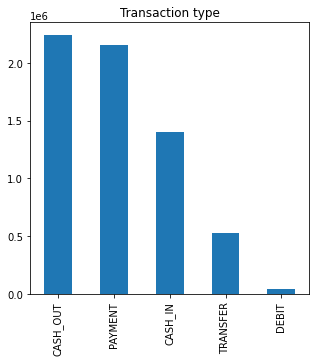

In [9]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(5,5))
plt.show()

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

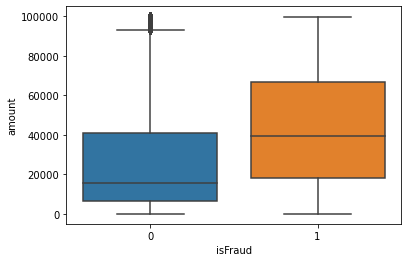

In [10]:
import seaborn as sns
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

In [11]:
df.groupby(['type', 'isFraud']).count()['step']

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

<AxesSubplot:xlabel='type', ylabel='amount'>

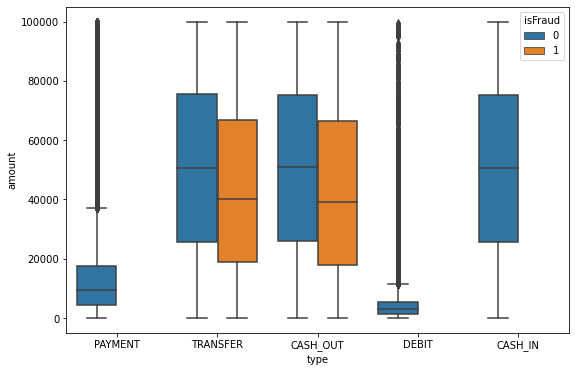

In [12]:
plt.figure(figsize=(9,6))
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df[df.amount < 1e5])

# 1 Use of isFlaggedFraud?
This attribute is set only for 16 times in total of 60lakh cases

In [13]:
len(df.loc[df.isFlaggedFraud==1])

16

In [14]:
df[df.isFlaggedFraud==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is because the transaction is halted. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.



In [15]:
dfTransfer = df.loc[df.type == 'TRANSFER']
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)])))


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


In [16]:
print('\nThe type of transactions in which the isFlaggedFraud is set {} \
'.format(df.loc[df.isFlaggedFraud==1].type.drop_duplicates().values))

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once, clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(df.loc[df.isFlaggedFraud==1].nameDest.isin(df.loc[df.isFlaggedFraud==0].nameDest)))) 


The type of transactions in which the isFlaggedFraud is set ['TRANSFER'] 

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


Even if isFraud always set when isFlaggedFraud is set, it is set only 16 times and seems to be unrelatable with any variable in the data.

# 2 Which types of transactions are fraud?

Note:  'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash.
The number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (

In [17]:
print('\nThe type of transactions in which the fraud has taken place are {}\
'.format(list(df.loc[df.isFraud==1].type.drop_duplicates().values))) 

print('Total number of fraudulent transactions for Cashout are {x} and for Transfer are {y}'.\
      format(x=len(df.loc[(df.isFraud==1)&(df.type=='CASH_OUT')]),y=len(df.loc[(df.isFraud==1)&(df.type=='TRANSFER')])))


The type of transactions in which the fraud has taken place are ['TRANSFER', 'CASH_OUT']
Total number of fraudulent transactions for Cashout are 4116 and for Transfer are 4097


# 3 Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions.


In [18]:
print('\nWithin the fraud transactions are there any accounts where\
the origin for TRANSFER is the destination in CASH_OUT? ')
df.loc[(df.isFraud==1) &( df.type=='TRANSFER')].\
nameDest.isin(df.loc[(df.isFraud==1) & (df.type=='CASH_OUT')].nameOrig).any()


Within the fraud transactions are there any accounts wherethe origin for TRANSFER is the destination in CASH_OUT? 


False

In [19]:
print('\nWithin the fraud transactions are there any accounts where\
the Destination for TRANSFER is the origin in CASH_OUT? ')
df[(df.isFraud==1) &( df.type=='TRANSFER')].\
nameOrig.isin(df[(df.isFraud==1) & (df.type=='CASH_OUT')].nameDest).any()


Within the fraud transactions are there any accounts wherethe Destination for TRANSFER is the origin in CASH_OUT? 


False

In [20]:
print("\nFraudulent TRANSFER whose destination are origin of genuine CASH_OUTs ")
dfFraudTransfer=df[(df.isFraud==1)&(df.type=='TRANSFER')]
dfNotFraud=df[df.isFraud==0]
dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]


Fraudulent TRANSFER whose destination are origin of genuine CASH_OUTs 


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0


In [21]:
print(df[df['nameOrig']=='C1714931087'])
#Only in this case the cashout is taking place after the transfer 

         step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
6149940   546  CASH_OUT  18091.05  C1714931087       197227.0       179135.95   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
6149940  C1339132632        66177.84        84268.89        0               0  


In [22]:
print(df[df['nameOrig']=='C423543548'])

         step      type     amount    nameOrig  oldbalanceOrg  newbalanceOrig  \
2186261   185  CASH_OUT  214555.85  C423543548            0.0             0.0   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2186261  C1066927674      4575179.83      4789735.69        0               0  


Accordingly nameOrig and nameDest does not seem to have much significance so we can drop these.

In [23]:
print(df[df['nameOrig']=='C1023330867'])

         step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
1168398   132  CASH_OUT  29084.28  C1023330867        51999.0        22914.72   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
1168398  C1422447255             0.0        29084.28        0               0  


# Data Cleaning

In [4]:
X = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y=X['isFraud']
X=X.drop(['isFraud', 'nameDest','nameOrig','isFlaggedFraud'], axis=1)
print(X.head())
print('\n\n\n\n')
print(Y.head())

    step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1  TRANSFER     181.00          181.0             0.0             0.0   
3      1  CASH_OUT     181.00          181.0             0.0         21182.0   
15     1  CASH_OUT  229133.94        15325.0             0.0          5083.0   
19     1  TRANSFER  215310.30          705.0             0.0         22425.0   
24     1  TRANSFER  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  
2             0.00  
3             0.00  
15        51513.44  
19            0.00  
24      2719172.89  





2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64


**Binary encoding of TRANSFER and CASH_OUT**

In [5]:
X.loc[X.type=='TRANSFER','type']=0
X.loc[X.type=='CASH_OUT','type']=1
X.type=X.type.astype(int)
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.00,0.0,0.00,0.00
3,1,1,181.00,181.00,0.0,21182.00,0.00
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44
19,1,0,215310.30,705.00,0.0,22425.00,0.00
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00


# Additional Features

In [6]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest
X[X['errorBalanceOrig']==X['errorBalanceOrig'].max()] 
print('\n\n')
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [7]:
print('\n The number of accounts in TRANSFER and CASH_OUT based on nameOrig {}'.format\
(len(df[((df.type=='TRANSFER') |(df.type=='CASH_OUT'))])))

print('\n The number of unique accounts in TRANSFER AND CASHOUT based on nameOrig {}'.format\
(len(df[((df.type=='TRANSFER') |(df.type=='CASH_OUT'))].groupby(df['nameOrig']))))


 The number of accounts in TRANSFER and CASH_OUT based on nameOrig 2770409

 The number of unique accounts in TRANSFER AND CASHOUT based on nameOrig 2768630


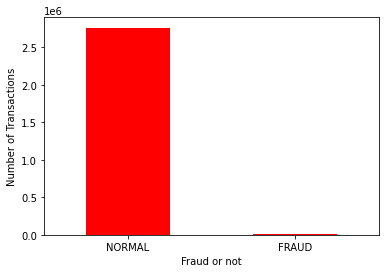

In [8]:
count_classes=pd.value_counts(Y)
count_classes.plot(kind='bar', rot=0,color=['red'])
plt.ylabel('Number of Transactions')
plt.xlabel('Fraud or not')
LABELS=['NORMAL','FRAUD']
plt.xticks(range(2),LABELS)
plt.show()

In [29]:
X.shape

(2770409, 9)

**Correlation of the independent variables**
1. oldbalanceOrg and newbalanceOrig are highly correlated  (oldbalanceOrig might give some insight about the fraud transaction)
2. oldbalanceDest and newbalanceDest are highly correlated (newBalanceDest might give some insight about the fraud transaction) 
3. amount and errorBalanceOrig are highly correlated (We can consider amount)

<AxesSubplot:>

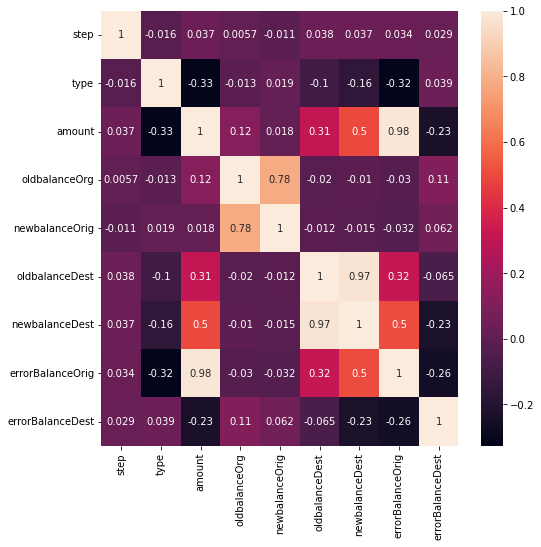

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(X.corr(), annot=True)

**Without removing the highly corelated independent variables applying RandomForest, takes 20-30mins. This gives the best accuracy with high precision and recall. Recall must be given higher weightage here as recalll tells us more about the transaction being is fraud and out model predics it wrong in this case the bank or the one lending money might face huge loss.**

In [12]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [35]:
rf_classifier=RandomForestClassifier().fit(x_train,y_train)

**Only 0.29% is fraud out of the total data. 99.71% data is non fraudulent **  

In [36]:
prediction1=rf_classifier.predict(x_test)
print(confusion_matrix(y_test,prediction1))
print(accuracy_score(y_test,prediction1))
print(classification_report(y_test,prediction1))

[[552436      0]
 [    11   1635]]
0.999980147342812
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       1.00      0.99      1.00      1646

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



**Feature Importances**

In [37]:
feature_importances=pd.DataFrame(rf_classifier.feature_importances_, index=x_train.columns,\
                                 columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
newbalanceOrig,0.396945
oldbalanceOrg,0.103565
errorBalanceOrig,0.091903
newbalanceDest,0.089487
type,0.087592
amount,0.073925
oldbalanceDest,0.059121
step,0.051540
errorBalanceDest,0.045921


**Without removing the highly corelated columns applying DecisionTreeClassifier**

In [31]:

dt_classifier= tree.DecisionTreeClassifier().fit(x_train,y_train)
print(dt_classifier.score(x_test,y_test))

0.9999657090466754


In [32]:
prediction2=dt_classifier.predict(x_test)
print(confusion_matrix(y_test,prediction2))
print(accuracy_score(y_test,prediction2))
print(classification_report(y_test,prediction2))

[[552426     10]
 [     9   1637]]
0.9999657090466754
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.99      0.99      0.99      1646

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



**Without removing the highly corelated columns applying LogisticRegression, recall and precision both come out to be very low in this case**

In [36]:
logistic_regression= LogisticRegression().fit(x_train,y_train)
logistic_regression.score(x_test,y_test)

0.996995029616555

In [37]:
prediction3=logistic_regression.predict(x_test)
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction3))
print(accuracy_score(y_test,prediction3))
print(classification_report(y_test,prediction3))

[[551690    746]
 [   919    727]]
0.996995029616555
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.49      0.44      0.47      1646

    accuracy                           1.00    554082
   macro avg       0.75      0.72      0.73    554082
weighted avg       1.00      1.00      1.00    554082



**Without removing the highly corelated columns applying SupportVectorMachine, takes nearly 2hrs**

In [ ]:
svm= SVC().fit(x_train,y_train)
svm.score(x_test,y_test)

Removing highly correlated independent variables

In [33]:
X_new=X.drop(['amount','oldbalanceDest'],axis=1)

In [34]:
X_new

,step,type,oldbalanceOrg,newbalanceOrig,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,0.0,0.00,0.00,1.810000e+02
3,1,1,181.00,0.0,0.00,0.00,2.136300e+04
15,1,1,15325.00,0.0,51513.44,213808.94,1.827035e+05
19,1,0,705.00,0.0,0.00,214605.30,2.377353e+05
24,1,0,10835.00,0.0,2719172.89,300850.89,-2.401220e+06
...,...,...,...,...,...,...,...
6362615,743,1,339682.13,0.0,339682.13,0.00,0.000000e+00
6362616,743,0,6311409.28,0.0,0.00,0.00,6.311409e+06
6362617,743,1,6311409.28,0.0,6379898.11,0.00,1.000000e-02
6362618,743,0,850002.52,0.0,0.00,0.00,8.500025e+05


In [35]:

x_new_train,x_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,test_size=0.20,random_state=42)

In [36]:

rf2_classifier=RandomForestClassifier().fit(x_new_train,y_new_train)
prediction4=rf2_classifier.predict(x_new_test)
print(confusion_matrix(y_new_test,prediction4))
print(accuracy_score(y_new_test,prediction4))
print(classification_report(y_new_test,prediction4))

[[552436      0]
 [    11   1635]]
0.999980147342812
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       1.00      0.99      1.00      1646

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [39]:
Y.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [40]:
8213/(2762196+8213)

0.002964544224336551

In [61]:
! pip install imbalanced-learn --user

^C


# Upsampling the data in ratio 98:2 i.e 98% is non fraud and 2% is fraud

In [ ]:
smote= SMOTETomek(sampling_strategy=.02)
X_sam, Y_sam= smote.fit_resample(X, Y)


In [ ]:
print('Original DataSet shape {} '.format(Counter(Y)))
print('Resampled DataSet shape {} '.format(Counter(Y_sam)))

# Model training using DecisionTreeClassifier

In [19]:
x_train_sam,x_test_sam,y_train_sam,y_test_sam=train_test_split(X_sam,Y_sam,test_size=0.20,random_state=42)

In [21]:
dt2_classifier= tree.DecisionTreeClassifier().fit(x_train_sam, y_train_sam)

In [25]:
prediction5=dt2_classifier.predict(x_test_sam)
print(accuracy_score(y_test_sam, prediction5))
print(confusion_matrix(y_test_sam, prediction5))
print(classification_report(y_test_sam, prediction5))

0.9999253942116566
[[552005     18]
 [    24  10912]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552023
           1       1.00      1.00      1.00     10936

    accuracy                           1.00    562959
   macro avg       1.00      1.00      1.00    562959
weighted avg       1.00      1.00      1.00    562959



# Model training with Random Forest Classifier

In [26]:
rf2_classifier= RandomForestClassifier().fit(x_train_sam, y_train_sam)
prediction6=rf2_classifier.predict(x_test_sam)
print(accuracy_score(y_test_sam, prediction6))
print(confusion_matrix(y_test_sam, prediction6))
print(classification_report(y_test_sam, prediction6))

0.999952039136065
[[552023      0]
 [    27  10909]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552023
           1       1.00      1.00      1.00     10936

    accuracy                           1.00    562959
   macro avg       1.00      1.00      1.00    562959
weighted avg       1.00      1.00      1.00    562959

